In [206]:
import math
import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.applications.densenet import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import pickle
import time
import json
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor




%matplotlib inline

In [207]:
data_AAPL_10_years = pd.read_csv('../datasets_10_years/AAPL-10.csv', index_col=[0], parse_dates=[0])
data_AAPL_10_years.columns = data_AAPL_10_years.columns.str.lower()

In [208]:
data_GOOG_10_years = pd.read_csv('../datasets_10_years/GOOG-10.csv', index_col=[0], parse_dates=[0])
data_GOOG_10_years.columns = data_GOOG_10_years.columns.str.lower()

In [209]:
data_META_10_years = pd.read_csv('../datasets_10_years/META-10.csv', index_col=[0], parse_dates=[0])
data_META_10_years.columns = data_META_10_years.columns.str.lower()

In [210]:
data_NFLX_10_years = pd.read_csv('../datasets_10_years/NFLX-10.csv', index_col=[0], parse_dates=[0])
data_NFLX_10_years.columns = data_NFLX_10_years.columns.str.lower()

In [211]:
data_TSLA_10_years = pd.read_csv('../datasets_10_years/TSLA-10.csv', index_col=[0], parse_dates=[0])
data_TSLA_10_years.columns = data_TSLA_10_years.columns.str.lower()

In [212]:
data_NVDA_10_years = pd.read_csv('../datasets_10_years/NVDA-10.csv', index_col=[0], parse_dates=[0])
data_NVDA_10_years.columns = data_NVDA_10_years.columns.str.lower()

In [213]:
data_MU_10_years = pd.read_csv('../datasets_10_years/MU-10.csv', index_col=[0], parse_dates=[0])
data_MU_10_years.columns = data_MU_10_years.columns.str.lower()

In [214]:
def split_sequence_new(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [215]:
def smape(A, F):
    return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


def metrics(y_true, y_pred):
    print('R2 Score:', r2_score(y_true=y_true, y_pred=y_pred))
    print('RMSE:', mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
    print('MAPE:', mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred))
    return r2_score(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred,
                                                                      squared=False), mean_absolute_percentage_error(
        y_true=y_true, y_pred=y_pred)

In [216]:


def fitting_per_year_700(company, key, iterator):
    total_start = time.time()
    best_r2 = 0
    best_rmse = 1000000
    best_mape = 1000

    best_year_r2 = 0
    best_year_rmse = 0
    best_year_mape = 0
    for year in np.unique(company.index.year)[0:len(np.unique(company.index.year)) - 1]:
        start = time.time()
        iter_data = company[f'{year}-01-01':]
        iter_data = iter_data['close']
        n_steps = 60
        X, y = split_sequence_new(iter_data, n_steps)

        train_size = len(X) - 60
        test_size = 60

        # scaler = MinMaxScaler(feature_range=(0, 1))
        # scaler.fit(features_train)

        features_train = X[:train_size]
        target_train = y[:train_size]
        features_test = X[len(X) - 60:]
        target_test = y[len(X) - 60:]

        # features_train = scaler.transform(features_train)
        # features_test = scaler.transform(features_test)

        model_per_day = RandomForestRegressor()
        model_per_day.fit(features_train, target_train)
        predictions_per_day = model_per_day.predict(features_test)
        print('ГОД:', year)
        r2, rmse, mape = metrics(y_true=target_test, y_pred=predictions_per_day)

        if r2 > best_r2:
            best_r2 = r2
            best_year_r2 = year
        if best_rmse > rmse:
            best_rmse = rmse
            best_year_rmse = year
        if best_mape > mape:
            best_mape = mape
            best_year_mape = year
        end = time.time() - start
        models_dict_700[key]['iteration_' + str(iterator)][str(year)] = {'r2': r2, 'rmse': rmse, 'mape': mape, 'time': end}
    total_end = time.time() - total_start
    models_dict_700[key]['iteration_' + str(iterator)]['total_time'] = total_end
    models_dict_700[key]['iteration_' + str(iterator)]['best_result'] = {'best_r2': best_r2, 'best_rmse': best_rmse, 'best_mape': best_mape}
    models_dict_700[key]['iteration_' + str(iterator)]['best_years'] = {'best_year_r2': best_year_r2, 'best_year_rmse': best_year_rmse,
                                      'best_year_mape': best_year_mape}



In [217]:
models_dict_700 = {}
company_list = ['AAPL', 'GOOG', 'META', 'MU', 'NFLX', 'NVDA', 'TSLA']
for company in company_list:
    models_dict_700[company] = {}
for company in company_list:
    for i in range(1, 11):
        models_dict_700[company]['iteration_' + str(i)] = {}

In [218]:
for i in range(1, 8):
    fitting_per_year_700(data_AAPL_10_years, 'AAPL', i)
    fitting_per_year_700(data_GOOG_10_years, 'GOOG', i)
    fitting_per_year_700(data_META_10_years, 'META', i)
    fitting_per_year_700(data_MU_10_years, 'MU', i)
    fitting_per_year_700(data_NFLX_10_years, 'NFLX', i)
    fitting_per_year_700(data_NVDA_10_years, 'NVDA', i)
    fitting_per_year_700(data_TSLA_10_years, 'TSLA', i)

#     with open(f'../dicts/models_dict_700_iteration_{i}.pickle', 'wb') as handle:
#         pickle.dump(models_dict_700, handle, protocol=pickle.HIGHEST_PROTOCOL)
#
#
# with open(f'../dicts/models_dict_700.pickle', 'wb') as handle:
#     pickle.dump(models_dict_700, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # with open('../dicts/models_dict.pickle', 'rb') as handle:
    #     b = pickle.load(handle)

ГОД: 2012
R2 Score: 0.7887031663986134
RMSE: 3.793797341955074
MAPE: 0.020321967515428595
ГОД: 2013
R2 Score: 0.7829095700824753
RMSE: 3.8454571183186976
MAPE: 0.02079789140607836
ГОД: 2014
R2 Score: 0.7806503382584742
RMSE: 3.865414913812095
MAPE: 0.02099195262579232
ГОД: 2015
R2 Score: 0.7924004537246436
RMSE: 3.76045878763722
MAPE: 0.02033207358807623
ГОД: 2016
R2 Score: 0.7916358904457017
RMSE: 3.7673770744280746
MAPE: 0.020203217531445123
ГОД: 2017
R2 Score: 0.7973985117802976
RMSE: 3.7149155798682325
MAPE: 0.01986607043351642
ГОД: 2018
R2 Score: 0.7929188220100765
RMSE: 3.7557609909304883
MAPE: 0.020454598820221777
ГОД: 2019
R2 Score: 0.7940149662405184
RMSE: 3.745807604067714
MAPE: 0.020351038484881862
ГОД: 2020
R2 Score: 0.7851610380551409
RMSE: 3.82546432367329
MAPE: 0.02058845508615555
ГОД: 2021
R2 Score: 0.7871488334553868
RMSE: 3.8077256609452443
MAPE: 0.021198764522641297
ГОД: 2022
R2 Score: 0.15430171416321425
RMSE: 7.589887848068184
MAPE: 0.04436659973020045
ГОД: 2012
R2

In [219]:
my_dict = models_dict_700


In [220]:
pprint.pprint(my_dict)
# with open('../dicts/models_dict_700_iteration_7.pickle', 'rb') as handle:
#     my_dict = pickle.load(handle)

{'AAPL': {'iteration_1': {'2012': {'mape': 0.020321967515428595,
                                   'r2': 0.7887031663986134,
                                   'rmse': 3.793797341955074,
                                   'time': 6.775817155838013},
                          '2013': {'mape': 0.02079789140607836,
                                   'r2': 0.7829095700824753,
                                   'rmse': 3.8454571183186976,
                                   'time': 5.401393890380859},
                          '2014': {'mape': 0.02099195262579232,
                                   'r2': 0.7806503382584742,
                                   'rmse': 3.865414913812095,
                                   'time': 4.763623952865601},
                          '2015': {'mape': 0.02033207358807623,
                                   'r2': 0.7924004537246436,
                                   'rmse': 3.76045878763722,
                                   'time': 4.0808022022247314}

In [221]:
company_list = ['AAPL', 'GOOG', 'META', 'MU', 'NFLX', 'NVDA', 'TSLA']
pprint.pprint(my_dict)

{'AAPL': {'iteration_1': {'2012': {'mape': 0.020321967515428595,
                                   'r2': 0.7887031663986134,
                                   'rmse': 3.793797341955074,
                                   'time': 6.775817155838013},
                          '2013': {'mape': 0.02079789140607836,
                                   'r2': 0.7829095700824753,
                                   'rmse': 3.8454571183186976,
                                   'time': 5.401393890380859},
                          '2014': {'mape': 0.02099195262579232,
                                   'r2': 0.7806503382584742,
                                   'rmse': 3.865414913812095,
                                   'time': 4.763623952865601},
                          '2015': {'mape': 0.02033207358807623,
                                   'r2': 0.7924004537246436,
                                   'rmse': 3.76045878763722,
                                   'time': 4.0808022022247314}

In [222]:
new_dict = {}
for company in company_list:
    new_dict[company] = {}
for company in company_list:
    for year in range(2012, 2023):
        new_dict[company][str(year)] = {}
new_dict

{'AAPL': {'2012': {},
  '2013': {},
  '2014': {},
  '2015': {},
  '2016': {},
  '2017': {},
  '2018': {},
  '2019': {},
  '2020': {},
  '2021': {},
  '2022': {}},
 'GOOG': {'2012': {},
  '2013': {},
  '2014': {},
  '2015': {},
  '2016': {},
  '2017': {},
  '2018': {},
  '2019': {},
  '2020': {},
  '2021': {},
  '2022': {}},
 'META': {'2012': {},
  '2013': {},
  '2014': {},
  '2015': {},
  '2016': {},
  '2017': {},
  '2018': {},
  '2019': {},
  '2020': {},
  '2021': {},
  '2022': {}},
 'MU': {'2012': {},
  '2013': {},
  '2014': {},
  '2015': {},
  '2016': {},
  '2017': {},
  '2018': {},
  '2019': {},
  '2020': {},
  '2021': {},
  '2022': {}},
 'NFLX': {'2012': {},
  '2013': {},
  '2014': {},
  '2015': {},
  '2016': {},
  '2017': {},
  '2018': {},
  '2019': {},
  '2020': {},
  '2021': {},
  '2022': {}},
 'NVDA': {'2012': {},
  '2013': {},
  '2014': {},
  '2015': {},
  '2016': {},
  '2017': {},
  '2018': {},
  '2019': {},
  '2020': {},
  '2021': {},
  '2022': {}},
 'TSLA': {'2012': {},
  

In [223]:
for company in company_list:
    for year in range(2012, 2023):
        total_r2 = 0
        total_r2_std = list()
        total_rmse = 0
        total_rmse_std = list()
        total_mape = 0
        total_mape_std = list()
        total_time = 0
        for i in range(1, 8):
            total_r2 += my_dict[company][f'iteration_{i}'][str(year)]['r2']
            total_r2_std.append(my_dict[company][f'iteration_{i}'][str(year)]['r2'])
            total_rmse += my_dict[company][f'iteration_{i}'][str(year)]['rmse']
            total_rmse_std.append(my_dict[company][f'iteration_{i}'][str(year)]['rmse'])
            total_mape += my_dict[company][f'iteration_{i}'][str(year)]['mape']
            total_mape_std.append(my_dict[company][f'iteration_{i}'][str(year)]['mape'])
            total_time += my_dict[company][f'iteration_{i}'][str(year)]['time']
            print('R2 = ', my_dict[company][f'iteration_{i}'][str(year)]['r2'])
            print('list std:', total_r2_std)
        new_dict[company][str(year)]['total_r2'] = total_r2 / 7
        new_dict[company][str(year)]['total_r2_std'] = np.std(total_r2_std)
        new_dict[company][str(year)]['total_rmse'] = total_rmse / 7
        new_dict[company][str(year)]['total_rmse_std'] = np.std(total_rmse_std)
        new_dict[company][str(year)]['total_mape'] = total_mape / 7
        new_dict[company][str(year)]['total_mape_std'] = np.std(total_mape_std)
        new_dict[company][str(year)]['total_time'] = total_time / 7
pprint.pprint(new_dict)

R2 =  0.7887031663986134
list std: [0.7887031663986134]
R2 =  0.7833993174710279
list std: [0.7887031663986134, 0.7833993174710279]
R2 =  0.7900116369059734
list std: [0.7887031663986134, 0.7833993174710279, 0.7900116369059734]
R2 =  0.7952441023647765
list std: [0.7887031663986134, 0.7833993174710279, 0.7900116369059734, 0.7952441023647765]
R2 =  0.7955474575801045
list std: [0.7887031663986134, 0.7833993174710279, 0.7900116369059734, 0.7952441023647765, 0.7955474575801045]
R2 =  0.7897019903513326
list std: [0.7887031663986134, 0.7833993174710279, 0.7900116369059734, 0.7952441023647765, 0.7955474575801045, 0.7897019903513326]
R2 =  0.7932112529540183
list std: [0.7887031663986134, 0.7833993174710279, 0.7900116369059734, 0.7952441023647765, 0.7955474575801045, 0.7897019903513326, 0.7932112529540183]
R2 =  0.7829095700824753
list std: [0.7829095700824753]
R2 =  0.7895012152875587
list std: [0.7829095700824753, 0.7895012152875587]
R2 =  0.7875431112557952
list std: [0.7829095700824753, 

In [224]:
def total_metrics(company):
    mape_list = list()
    mape_std_list = list()
    r2_list = list()
    r2_std_list = list()
    rmse_list = list()
    rmse_std_list = list()
    time_list = list()

    for year in range(2012, 2023):
        mape_list.append(new_dict[company][str(year)]['total_mape'])
        mape_std_list.append(new_dict[company][str(year)]['total_mape_std'])
        r2_list.append(new_dict[company][str(year)]['total_r2'])
        r2_std_list.append(new_dict[company][str(year)]['total_r2_std'])
        rmse_list.append(new_dict[company][str(year)]['total_rmse'])
        rmse_std_list.append(new_dict[company][str(year)]['total_rmse_std'])
        time_list.append(new_dict[company][str(year)]['total_time'])
    return pd.Series(mape_list, index=range(2012, 2023)), pd.Series(r2_list, index=range(2012, 2023)), pd.Series(rmse_list, index=range(2012, 2023)), pd.Series(time_list, index=range(2012, 2023)), pd.Series(mape_std_list, index=range(2012, 2023)), pd.Series(r2_std_list, index=range(2012, 2023)), pd.Series(rmse_std_list, index=range(2012, 2023))

In [225]:
def total_plot(total_mape, total_r2, total_rmse, total_time, total_mape_std, total_r2_std, total_rmse_std, company):
    data = pd.read_csv(f'../datasets_10_years/{company}-10.csv', index_col=[0], parse_dates=[0])
    data.columns = data.columns.str.lower()
    plt.figure(figsize=(10, 5))
    plt.title(f'Stock Prices History {company}')
    data['close'].plot()
    plt.xlabel('Date')
    plt.ylabel('Prices ($)')
    plt.axhline(data.tail(60)['close'].min(), color='orange')
    plt.axhline(data.tail(60)['close'].max(), color='orange')
    plt.show()


    total_mape.plot(style='go-', figsize=(10, 4), label='MAPE')
    plt.title(f'MAPE {company}')
    plt.ylim(-1, 1)
    plt.legend()
    for year in range(2012, 2023):
        for i in range(1, 8):
            plt.scatter(year, my_dict[company][f'iteration_{i}'][str(year)]['mape'], color='orange', marker='o', alpha=0.3)
    plt.show()
    print(total_mape_std)


    total_r2.plot(style='go-', figsize=(10, 4), label='R2')
    plt.title(f'R2 {company}')
    plt.ylim(-1, 1)
    plt.legend()
    for year in range(2012, 2023):
        for i in range(1, 8):
            plt.scatter(year, my_dict[company][f'iteration_{i}'][str(year)]['r2'], color='orange', marker='o', alpha=0.3)
    plt.show()
    print(total_r2_std)
    total_rmse.plot(style='go-', figsize=(10, 4), label='RMSE')
    plt.title(f'RMSE {company}')
    plt.ylim(-5, 50)
    plt.legend()

    for year in range(2012, 2023):
        for i in range(1, 8):
            plt.scatter(year, my_dict[company][f'iteration_{i}'][str(year)]['rmse'], color='orange', marker='o', alpha=0.3)
    plt.show()
    print(total_rmse_std)
    total_time.plot(style='go-', figsize=(10, 4), label='TIME')
    plt.title(f'TIME {company}')
    plt.legend()
    plt.show()

In [231]:
def total_metrics_and_plot(company):
    total_mape, total_r2, total_rmse, total_time, total_mape_std, total_r2_std, total_rmse_std  = total_metrics(company)
    total_plot(total_mape, total_r2, total_rmse, total_time, total_mape_std, total_r2_std, total_rmse_std, company)

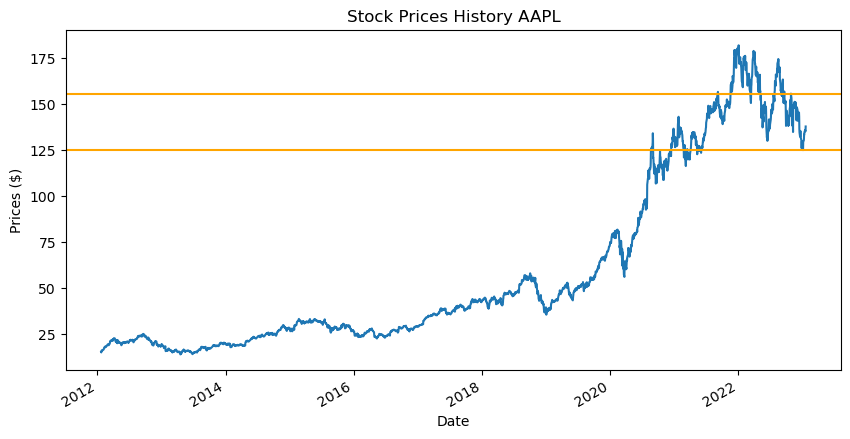

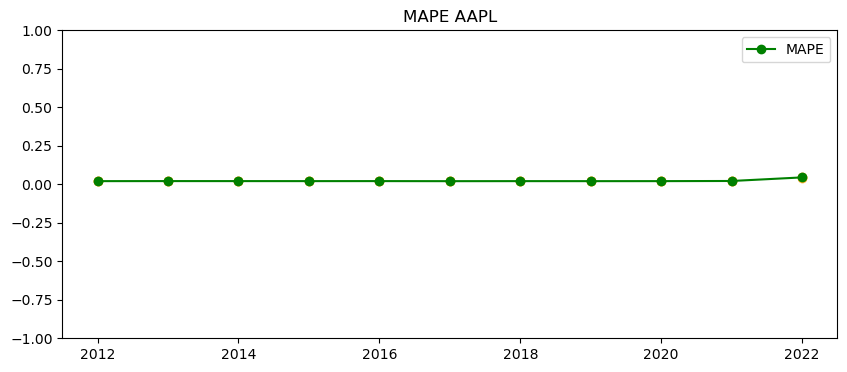

2012    0.000226
2013    0.000237
2014    0.000379
2015    0.000197
2016    0.000311
2017    0.000324
2018    0.000333
2019    0.000254
2020    0.000280
2021    0.000311
2022    0.002183
dtype: float64


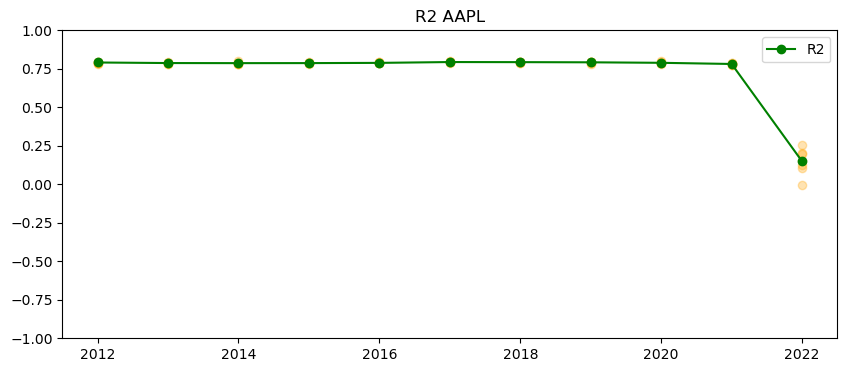

2012    0.003948
2013    0.003037
2014    0.005844
2015    0.002605
2016    0.002953
2017    0.002203
2018    0.002819
2019    0.004328
2020    0.004668
2021    0.004228
2022    0.077939
dtype: float64


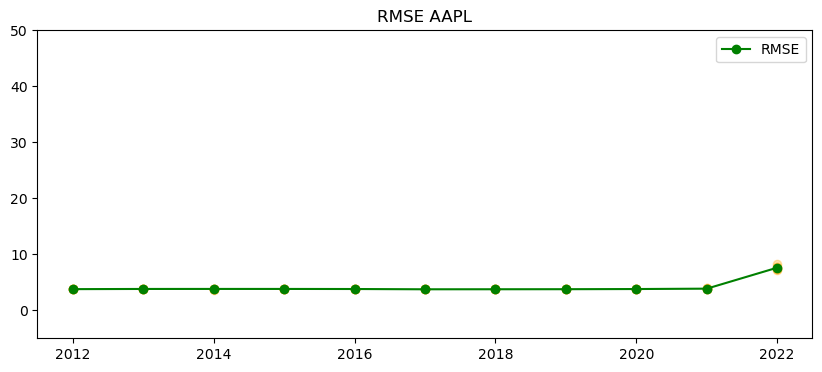

2012    0.035539
2013    0.027166
2014    0.052609
2015    0.023361
2016    0.026518
2017    0.020002
2018    0.025568
2019    0.038988
2020    0.042121
2021    0.037304
2022    0.344349
dtype: float64


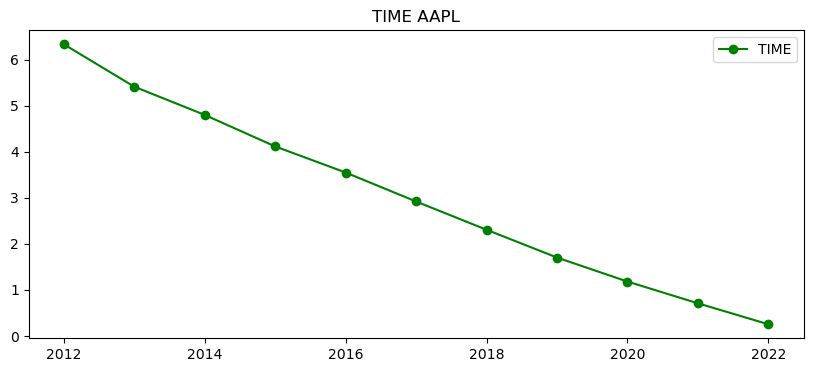

In [232]:
total_metrics_and_plot('AAPL')

#fill 2 линии сверхус низу
#высокочастотные ряды
#другая модель
#подходы

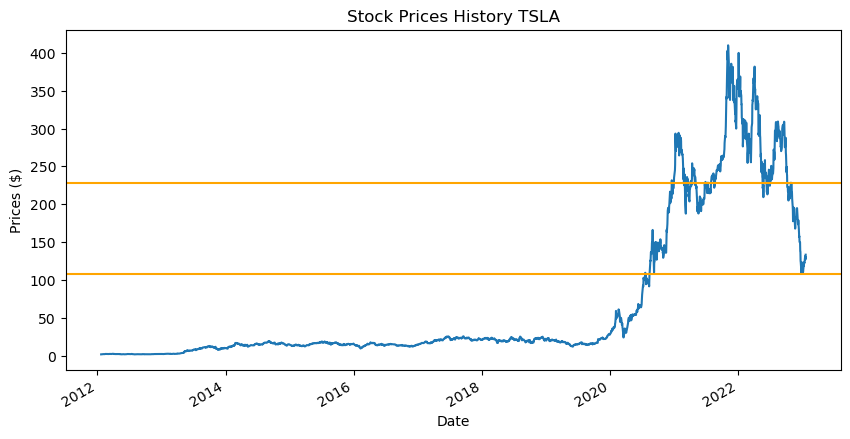

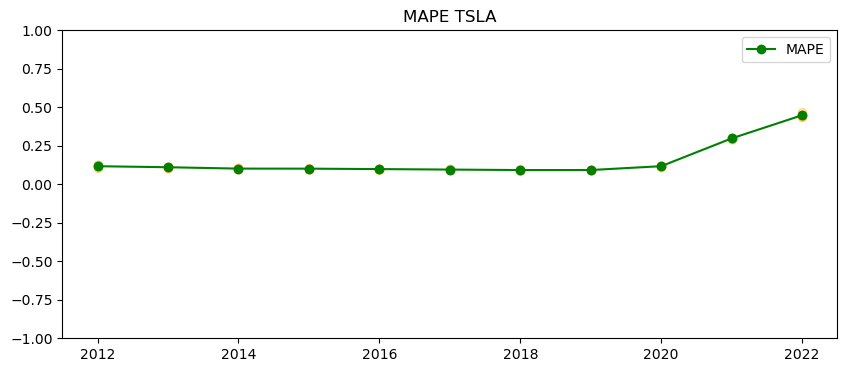

2012    0.006319
2013    0.002241
2014    0.003526
2015    0.002687
2016    0.001820
2017    0.002535
2018    0.002354
2019    0.001392
2020    0.003118
2021    0.002102
2022    0.009002
dtype: float64


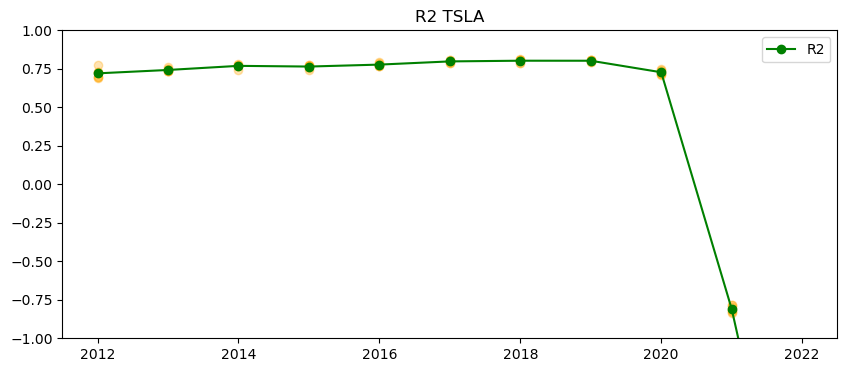

2012    0.025672
2013    0.008670
2014    0.011117
2015    0.010787
2016    0.009519
2017    0.008264
2018    0.009059
2019    0.005856
2020    0.013765
2021    0.019143
2022    0.151218
dtype: float64


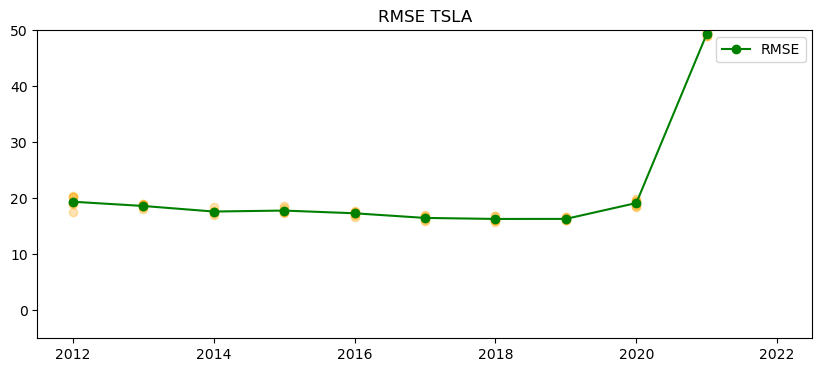

2012    0.911209
2013    0.315217
2014    0.419582
2015    0.403033
2016    0.372010
2017    0.337842
2018    0.372529
2019    0.240910
2020    0.485776
2021    0.261205
2022    1.395257
dtype: float64


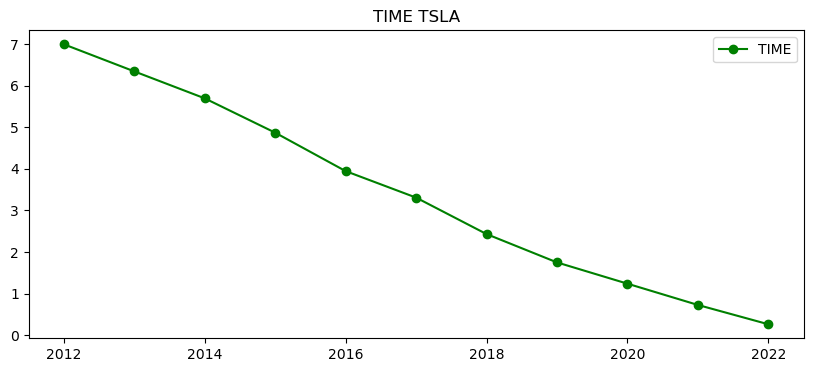

In [233]:
total_metrics_and_plot('TSLA')

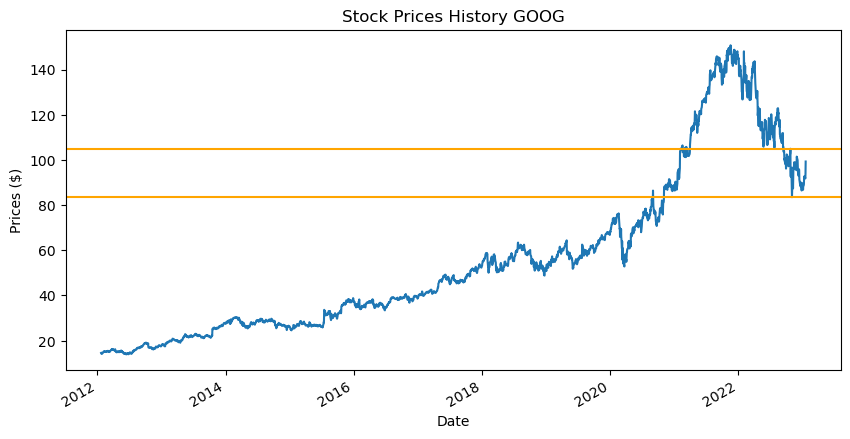

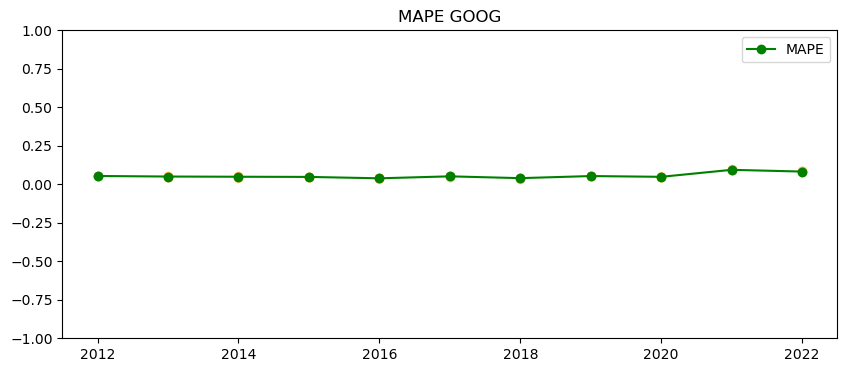

2012    0.001677
2013    0.001791
2014    0.002839
2015    0.001613
2016    0.000662
2017    0.002863
2018    0.002326
2019    0.001803
2020    0.002379
2021    0.001712
2022    0.001479
dtype: float64


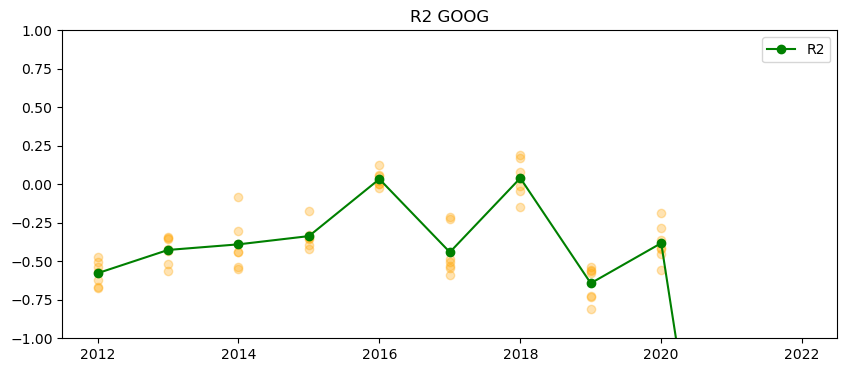

2012    0.073856
2013    0.081201
2014    0.148448
2015    0.072727
2016    0.045486
2017    0.143974
2018    0.110724
2019    0.100563
2020    0.111878
2021    0.127406
2022    0.098275
dtype: float64


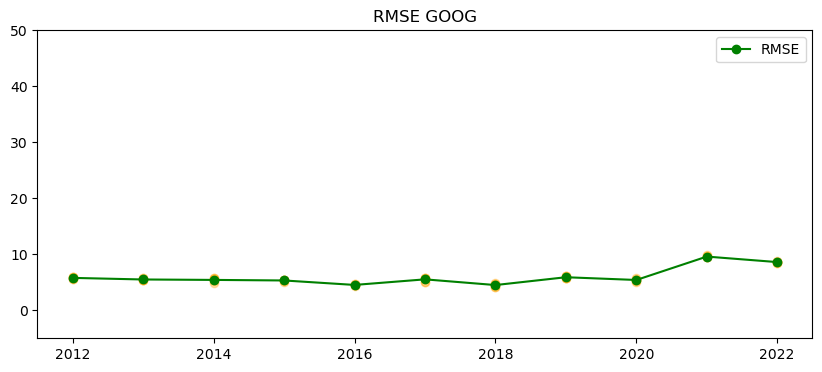

2012    0.135414
2013    0.155558
2014    0.299214
2015    0.147694
2016    0.107595
2017    0.282544
2018    0.259824
2019    0.179618
2020    0.220881
2021    0.140385
2022    0.121247
dtype: float64


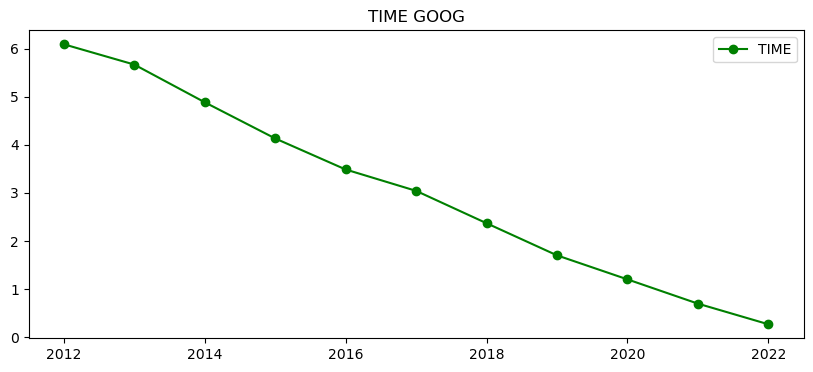

In [234]:
total_metrics_and_plot('GOOG')

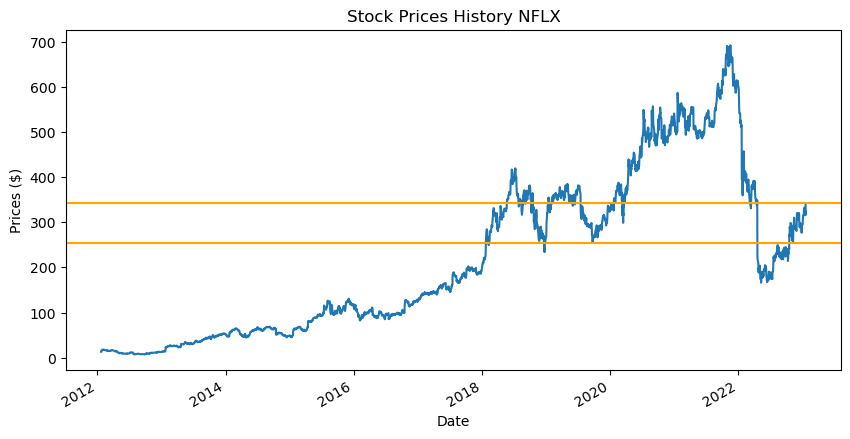

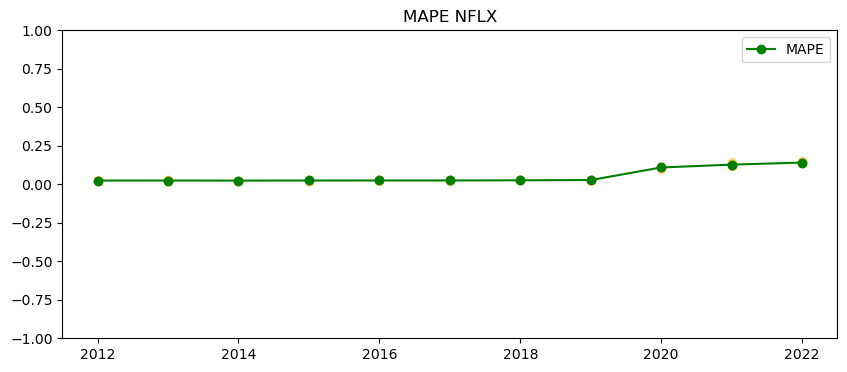

2012    0.000460
2013    0.000432
2014    0.000202
2015    0.000365
2016    0.000134
2017    0.000179
2018    0.000318
2019    0.000455
2020    0.003833
2021    0.008234
2022    0.004361
dtype: float64


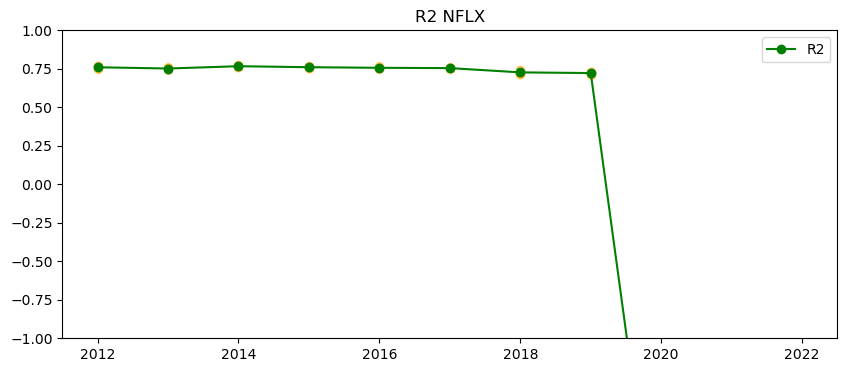

2012    0.007202
2013    0.005639
2014    0.004254
2015    0.006039
2016    0.005355
2017    0.002865
2018    0.010412
2019    0.006970
2020    0.289206
2021    0.598675
2022    0.320596
dtype: float64


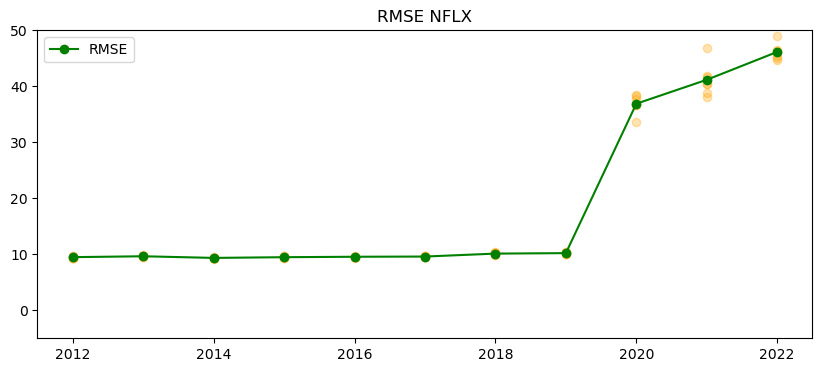

2012    0.141679
2013    0.109510
2014    0.085196
2015    0.119763
2016    0.104927
2017    0.055999
2018    0.194124
2019    0.127776
2020    1.505112
2021    2.631610
2022    1.281942
dtype: float64


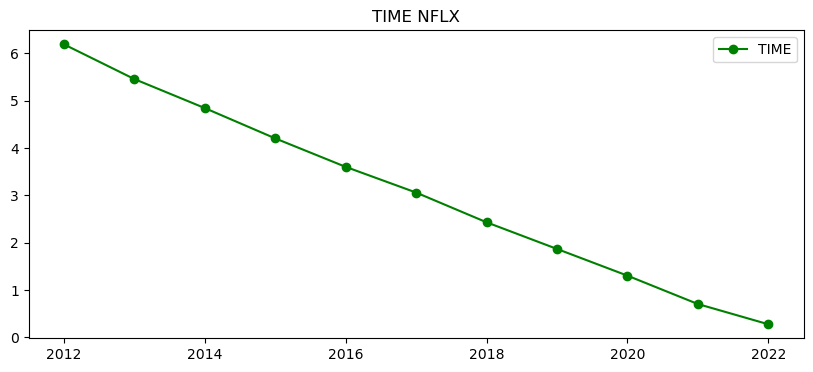

In [235]:
total_metrics_and_plot('NFLX')